# Import del Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.exceptions import ConvergenceWarning
import warnings
from scipy.stats import t
from scipy.stats import norm
import math
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import shapiro
import scipy.stats as stats
import statsmodels.api as sm


## Import dati meteroologici

In [2]:
#Caricamento del dataset contenente i dati meteorologici
weather_data = pd.read_csv("../data/raw/weather_prediction_dataset.csv")

print(f"Il weather dataset ha {weather_data.shape[0]} record e {weather_data.shape[1]} colonne")

print("Etichette colonne weather_data:")
print(weather_data.columns)


Il weather dataset ha 3654 record e 165 colonne
Etichette colonne weather_data:
Index(['DATE', 'MONTH', 'BASEL_cloud_cover', 'BASEL_humidity',
       'BASEL_pressure', 'BASEL_global_radiation', 'BASEL_precipitation',
       'BASEL_sunshine', 'BASEL_temp_mean', 'BASEL_temp_min',
       ...
       'STOCKHOLM_temp_min', 'STOCKHOLM_temp_max', 'TOURS_wind_speed',
       'TOURS_humidity', 'TOURS_pressure', 'TOURS_global_radiation',
       'TOURS_precipitation', 'TOURS_temp_mean', 'TOURS_temp_min',
       'TOURS_temp_max'],
      dtype='object', length=165)


*weather_data* contiene 3654 registrazioni meteorologiche giornaliere per un certo numero di città europee. Ogni registrazione contiene i valori di diversi parametri meteorologici, differenti in base alla città.

## Import condizioni meteorologiche

In [3]:
#Caricamento del dataset indicante le registrazioni con meteo da bbq e quelle non
classification_data = pd.read_csv("../data/raw/weather_prediction_bbq_labels.csv")

print(f"Il classification dataset ha {classification_data.shape[0]} record e {classification_data.shape[1]} colonne")

print("Etichette colonne classification_data:")
print(classification_data.columns)


Il classification dataset ha 3654 record e 18 colonne
Etichette colonne classification_data:
Index(['DATE', 'BASEL_BBQ_weather', 'BUDAPEST_BBQ_weather', 'DE_BBQ_weather',
       'DRESDEN_BBQ_weather', 'DUSSELDORF_BBQ_weather', 'HEATHROW_BBQ_weather',
       'KASSEL_BBQ_weather', 'LJUBLJANA_BBQ_weather', 'MAASTRICHT_BBQ_weather',
       'MALMO_BBQ_weather', 'MONTELIMAR_BBQ_weather', 'MUENCHEN_BBQ_weather',
       'OSLO_BBQ_weather', 'PERPIGNAN_BBQ_weather', 'SONNBLICK_BBQ_weather',
       'STOCKHOLM_BBQ_weather', 'TOURS_BBQ_weather'],
      dtype='object')


*classificazion_data* associa ad ognuna delle registrazione di *weather_data* un valore true e false per ogni città, a seconda che il meteo sia considerato adatto (true) o non adatto (false) al barbeque.
Il BBQ meteo è sostanzialmente equiparabile a quello che si considera bel tempo, ossia un meteo adatto a passare tempo all'aperto.

## Analisi struttura dataset

In [4]:
#Calcolo numero di parametri meteorologici registrati per città
conteggi = {}

for item in weather_data.columns[2:]:
    citta = item.split("_")[0]
    if citta in conteggi:
        conteggi[citta] += 1
    else:
        conteggi[citta] = 1

#Stampa città e numero di parametri associati
print("Numero parametri meteorologici per città:")
for citta, conteggio in conteggi.items():
    print(f"{citta}: {conteggio}")    
print()

#Numero città registrate nei database
print(f"Numero città weather dataset: {len(conteggi.keys())}")
print(f"Numero città classification dataset: {len(classification_data.columns) -1}")

Numero parametri meteorologici per città:
BASEL: 9
BUDAPEST: 8
DE: 11
DRESDEN: 10
DUSSELDORF: 11
HEATHROW: 9
KASSEL: 10
LJUBLJANA: 10
MAASTRICHT: 11
MALMO: 5
MONTELIMAR: 8
MUENCHEN: 11
OSLO: 11
PERPIGNAN: 8
ROMA: 8
SONNBLICK: 8
STOCKHOLM: 7
TOURS: 8

Numero città weather dataset: 18
Numero città classification dataset: 17


Tramite un dizionario vengono contanti il **numero di parametri meteorologici registrati per ogni città**. Si noti che il numero massimo di parametri registrati per una singola città è **11**.
Viene inoltre effettuato un conteggio delle città registrate nei due dataset, osservando che in *classification_data* ne sia presente una in meno. Da una rapida lettura dei campi del db è possibile osservare che manchi ROMA.

## Selezione città: OSLO

In [5]:
#Selezione città e individuazione indici nel dataset
citta = "OSLO"
chiavi = list(conteggi.keys()) #lista città
valori = list(conteggi.values()) #num parametri associati ad ogni citta
indici_citta = [0,0]
indici_citta[0] = sum(valori[:chiavi.index(citta)]) + 2 #posizione prima colonna della città
indici_citta[1] = indici_citta[0] + conteggi[citta] #posizione ultima colonna della città

#Costruzione dataset città
df = weather_data.iloc[:, indici_citta[0] : indici_citta[1]] #dati meteorologici città
df["MONTH"] = weather_data["MONTH"]
df["BBQ"] = classification_data[citta + "_BBQ_weather"] 
df["DATE"] = classification_data["DATE"]
df.to_csv(f"../data/processed/{citta}_weather_dataset.csv") #salvataggio del dataset creato

Le città con 11 parametri meteorologici sono DUSSELDORF, MAASTRICHT, MUENCHEN, OSLO. Poichè la classificazione finale si basa sui dati meteorologici, e poichè essi sono influenzati dalla posizione geografica della città, è stato scelto di operare su una sola città. 
La scelta ricade su OSLO. 
Vengono individuate le colonne del *weather_data* ds relative ad OSLO, vengono estratte e unite con la colonna di classificazione della città di OSLO contenuta nel *classification_data* ds, ottenendo così il dataset su cui lavorare.

# Pre-processing

## Rimozione NaN e duplicati

In [6]:
#Analisi valori nulli
print("Valori NaN per colonna:")
print(df.isnull().sum())

#Rimozione valori nulli
df.dropna(inplace = True)

#Rimozione duplicati
df.drop_duplicates(inplace=True)

Valori NaN per colonna:
OSLO_cloud_cover         0
OSLO_wind_speed          0
OSLO_wind_gust           0
OSLO_humidity            0
OSLO_pressure            0
OSLO_global_radiation    0
OSLO_precipitation       0
OSLO_sunshine            0
OSLO_temp_mean           0
OSLO_temp_min            0
OSLO_temp_max            0
MONTH                    0
BBQ                      0
DATE                     0
dtype: int64


## Variabili categoriche e numeriche

In [7]:
#Imposta variabili categoriche quelle non numeriche
num_type = ["float64", "int64"]

for col in df.columns:
    print(f"{col} type: {df[col].dtype}.")
    if df[col].dtype not in num_type:
        df[col] = df[col].astype("category")
        print(f"{col} type: {df[col].dtype}.")
    print("-" * 45)

#df["MONTH"]=df["MONTH"].astype("category")
df["BBQ"]=df["BBQ"].astype("category")
df["DATE"] = df["DATE"].astype("category")

#Sub-dataset con solo colonne numeriche
colonne_numeriche = df.select_dtypes(include=num_type)

#Rimozione della colonna con le date
df.drop(columns = ["DATE"], inplace=True)

OSLO_cloud_cover type: int64.
---------------------------------------------
OSLO_wind_speed type: float64.
---------------------------------------------
OSLO_wind_gust type: float64.
---------------------------------------------
OSLO_humidity type: float64.
---------------------------------------------
OSLO_pressure type: float64.
---------------------------------------------
OSLO_global_radiation type: float64.
---------------------------------------------
OSLO_precipitation type: float64.
---------------------------------------------
OSLO_sunshine type: float64.
---------------------------------------------
OSLO_temp_mean type: float64.
---------------------------------------------
OSLO_temp_min type: float64.
---------------------------------------------
OSLO_temp_max type: float64.
---------------------------------------------
MONTH type: int64.
---------------------------------------------
BBQ type: bool.
BBQ type: category.
---------------------------------------------
DATE type:

## Outliers

### Boxplot

In [8]:
# Metodo per nascondere gli assi non utilizzati (grafici vuoti)
def rimuovi_assi_superflui():
    for j in range(i + 1, 3 * 4):
        fig.delaxes(axes[j // 4, j % 4])


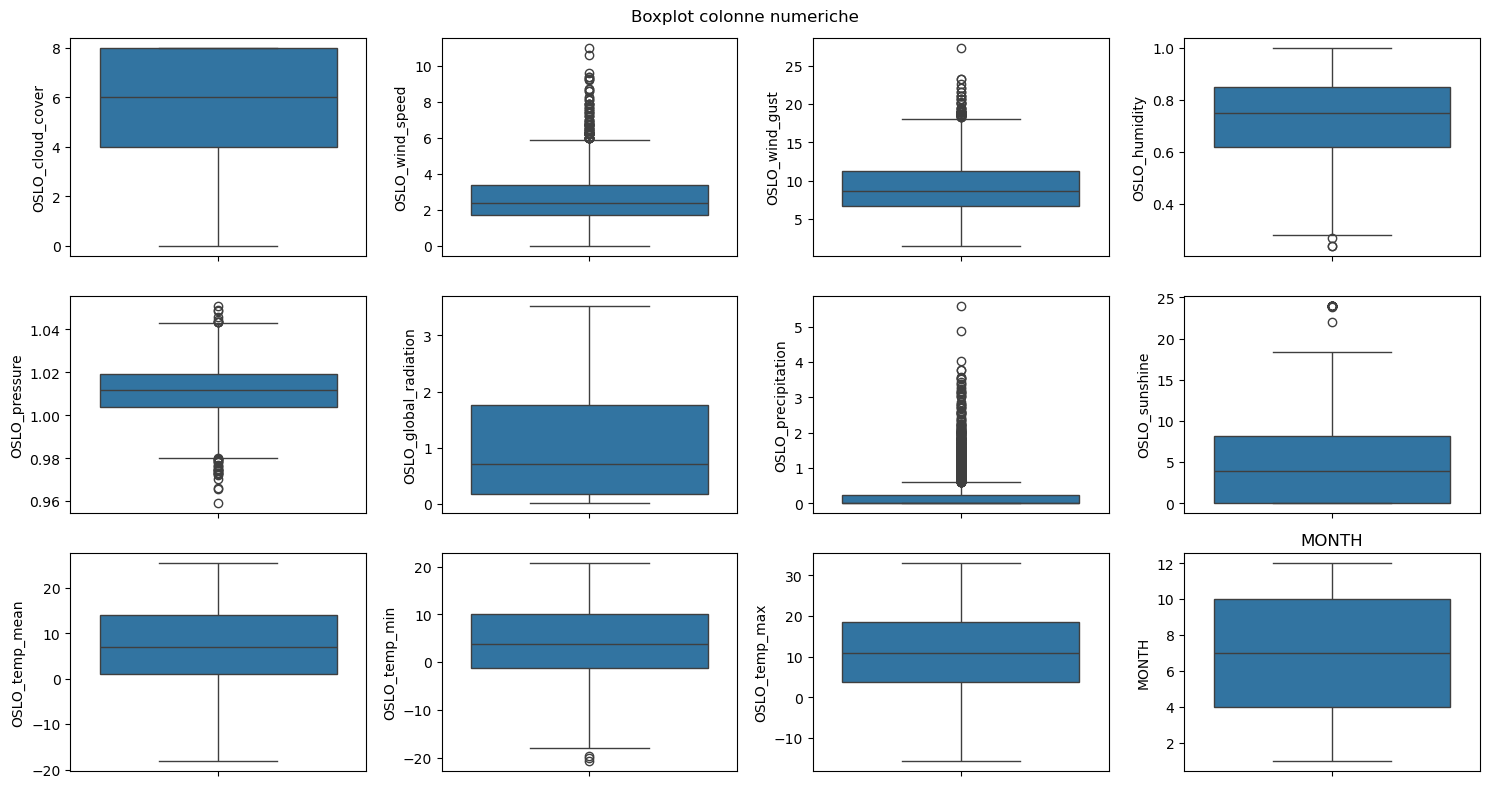

In [9]:
#BoxPlot delle colonne numeriche per individuazione outliers
#Viene scelta una distribuzione su 3 righe e 4 colonne perchè il numero massimo di features meteorologiche è 11
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 8))

for i, colonna in enumerate(colonne_numeriche):
    ax = axes[i // 4, i % 4]
    sns.boxplot(data = df[colonna], ax = ax)
    plt.title(f"{colonna}")

rimuovi_assi_superflui()
plt.suptitle("Boxplot colonne numeriche")
plt.tight_layout()
plt.show()

I boxplot mostrano i 5 numeri di sintesi per ogni feature, indicando i potenziali outliers (distanza dal centro superiore a 1,5 volte l'ampiezza IQR). Va considerato che le condizioni meteorologiche a volte, seppur non frequentemente, possono risultare estreme. Questo è valido soprattutto per la temperatura, per le precipitazioni e per il vento. 

### Valutazione outliers

In [10]:
#Intervalli feature numeriche
estremi = colonne_numeriche.describe().loc[["min", "max"]]
print(estremi)

     OSLO_cloud_cover  OSLO_wind_speed  OSLO_wind_gust  OSLO_humidity  \
min               0.0              0.0             1.5           0.24   
max               8.0             11.0            27.3           1.00   

     OSLO_pressure  OSLO_global_radiation  OSLO_precipitation  OSLO_sunshine  \
min         0.9590                   0.01                 0.0            0.0   
max         1.0511                   3.53                 5.6           24.0   

     OSLO_temp_mean  OSLO_temp_min  OSLO_temp_max  MONTH  
min           -18.1          -20.7          -15.6    1.0  
max            25.4           20.7           33.0   12.0  


I valori estremi delle temperature sembrano essere ragionevoli. Considerando i dati storici, la minor temperatura mai registrata ad Oslo corrisponde a -26.3 C, mentre la maggiore 35.6C

La nuvolosità del cielo è misurata in okta, un indice che assume valori in [0, 9], con 0 cielo limpido e 9 cielo completamente invisibile (nebbia o neve). Valore 8 okta indica cielo completamente coperto.

In [11]:
#Rimozione delle giornate con più di 20 ore di luce
df = df[df[f"{citta}_sunshine"] < 20]

Considerando che Oslo risiede sotto il circolo polare artico, e anche sotto il 60esimo grado di latitudine a cui si può verificare il fenomeno del *sole di mezzanotte*, si considerano errati, e quindi da eliminare, i record con più di 20 ore di luce.

In [12]:
#Rimozione delle temperature minime sotto lo 0 se si verificano nei mesi estivi
df = df[~((df[f"{citta}_temp_min"] < 0) & (df['MONTH'].isin([6, 7, 8])))]

Rimuove le registrazioni avvenute nei mesi estivi (Giugno, Luglio, Agosto) in cui la temperatura minima è sotto 0 gradi. 

### Rimozione outliers sospetti

In [13]:
def calcola_outliers(valori):
    # Converte in array numpy
    valori = np.array(valori)

    # Calcola il primo quartile (Q1), il terzo quartile (Q3) e IQR
    Q1 = np.percentile(valori, 25)
    Q3 = np.percentile(valori, 75)
    IQR = Q3 - Q1
    
    # Calcola i limiti per gli outliers sospetti
    limite_inferiore = Q1 - 3 * IQR
    limite_superiore = Q3 + 3 * IQR
    
    return limite_inferiore, limite_superiore

# Rimozione outliers sospetti
for colonna in ["_wind_speed", "_wind_gust", "_humidity", "_pressure", "_precipitation"]:
    colonna = f"{citta}" + colonna
    limite_inferiore, limite_superiore = calcola_outliers(df[colonna])
    df = df[(df[colonna] > limite_inferiore) & (df[colonna] < limite_superiore)]

Escludiamo gli outliers sospetti (distanza dal centro superiore a 3 volte l'ampiezza IQR) delle colonne relative a velocità del vento, velocità delle raffiche di vento, umidità, pressione e precipitazioni. Adottiamo un approccio conservativo in virtù della possibilità di registrare fenomeni meteorologici estremi con una certa frequenza specialmente per effetto del *global warming*.

In [14]:
#Aggiornamento del sub-dataset con solo colonne numeriche
colonne_numeriche = df.select_dtypes(include=num_type)

Viene aggiornato anche il sub-dataset con solo le colonne numeriche rimuovendo i record considerati outliers.

In [15]:
#Export dataset ripulito
df.to_csv(f"../data/processed/{citta}_weather_dataset_clean.csv")

# EDA

## Distribuzione valori

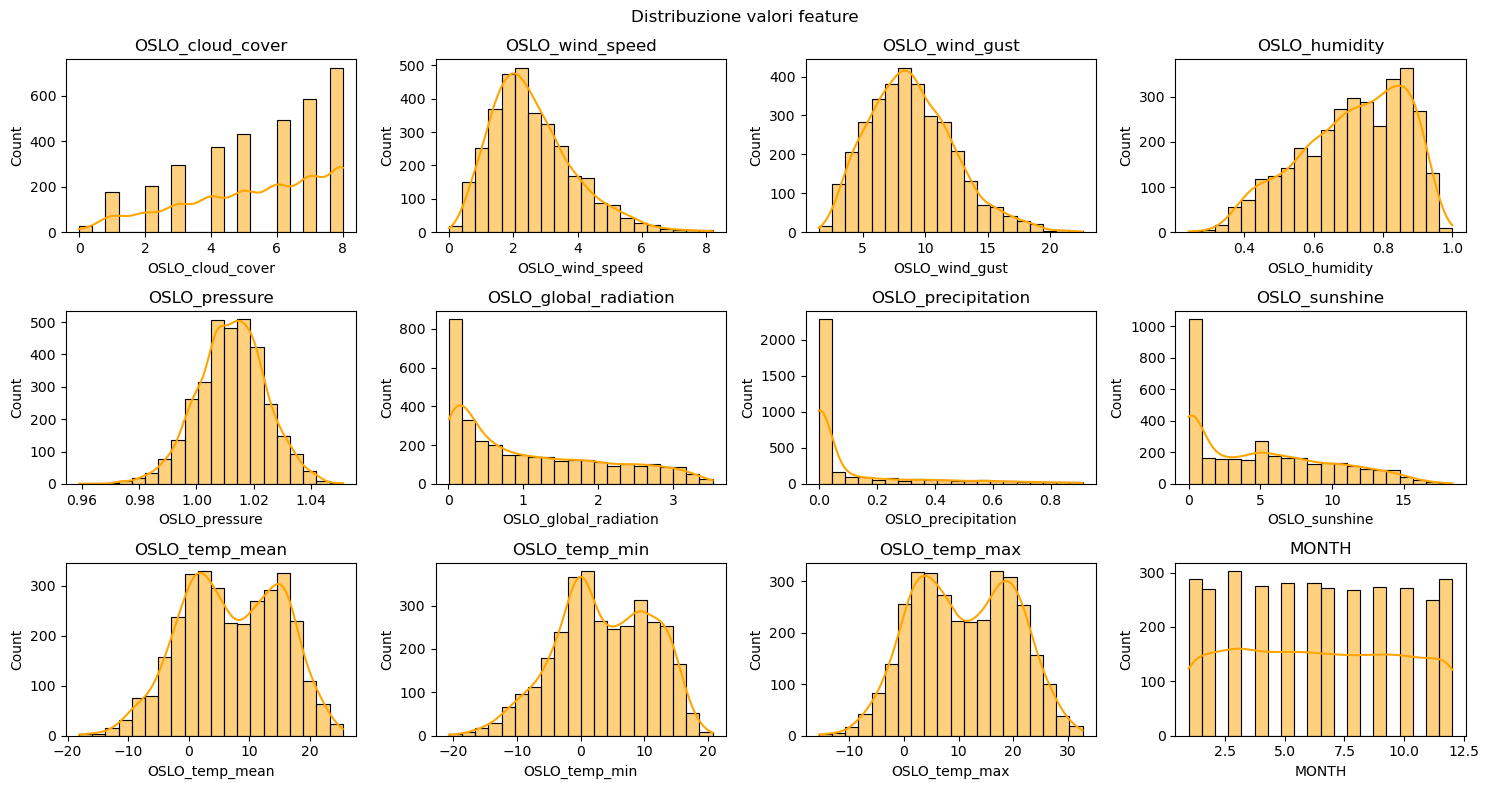

In [16]:
#Distribuzione valori colonne numeriche
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 8))


for i, colonna in enumerate(colonne_numeriche):
    ax = axes[i // 4, i % 4]
    sns.histplot(df[colonna], kde = True, bins = 20, color="orange", ax = ax)
    ax.set_title(f"{colonna}")

rimuovi_assi_superflui()
plt.suptitle("Distribuzione valori feature")
plt.tight_layout()
plt.show()

L'irraggiamento solare, le precipitazioni e le ore di sole hanno una distribuzione fortemente asimmetrica a sinistra. Le temperature hanno distribuzione normale bimodale con i due picchi associati ad inverno ed estate.
La nuvolosità ha distribuzione discreta.

## Distribuzione mensile delle registrazioni

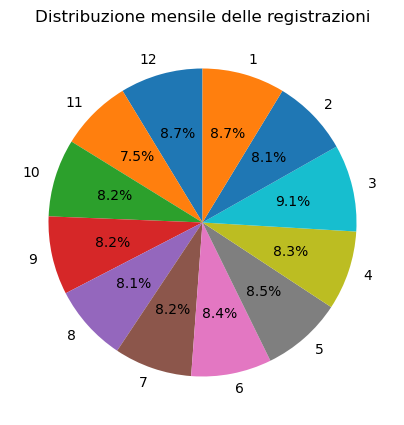

In [17]:
#Ripartizione dei record nei vari mesi dell'anno
plt.figure(figsize = (5,5))
temp = df["MONTH"].value_counts().sort_index()[::-1]
plt.pie(temp.values,
        labels = temp.index,
        startangle = 90,
        autopct='%.1f%%')
plt.title("Distribuzione mensile delle registrazioni")
plt.show()

La distribuzione delle registrazioni nei mesi dell'anno, al netto della rimozione degli outliers, rimane sostanzialmente bilanciata

## Distribuzione delle classi

### Distribuzione generale

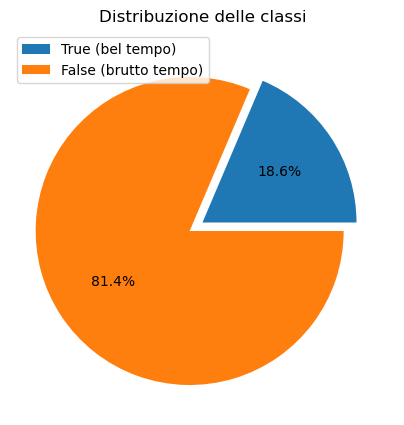

In [18]:
#Divisione dei record in base alla condizione meteo
plt.figure(figsize = (5,5))
plt.pie(df["BBQ"].value_counts().sort_index()[::-1],#mette prima i True e poi i False
        explode=[0, 0.1], #distanza delle due fette di torta
        autopct='%.1f%%') #formattazione della percentuale
plt.legend(["True (bel tempo)", "False (brutto tempo)"]);
plt.title("Distribuzione delle classi")
plt.show()

La maggioranza delle registrazioni sono relative a giorni con meteo non adatto al barbeque. Questo sbilanciamento può comportare problemi di *class imbalance* nell'algoritmo di classificazione.

### Distribuzione in base ai mesi

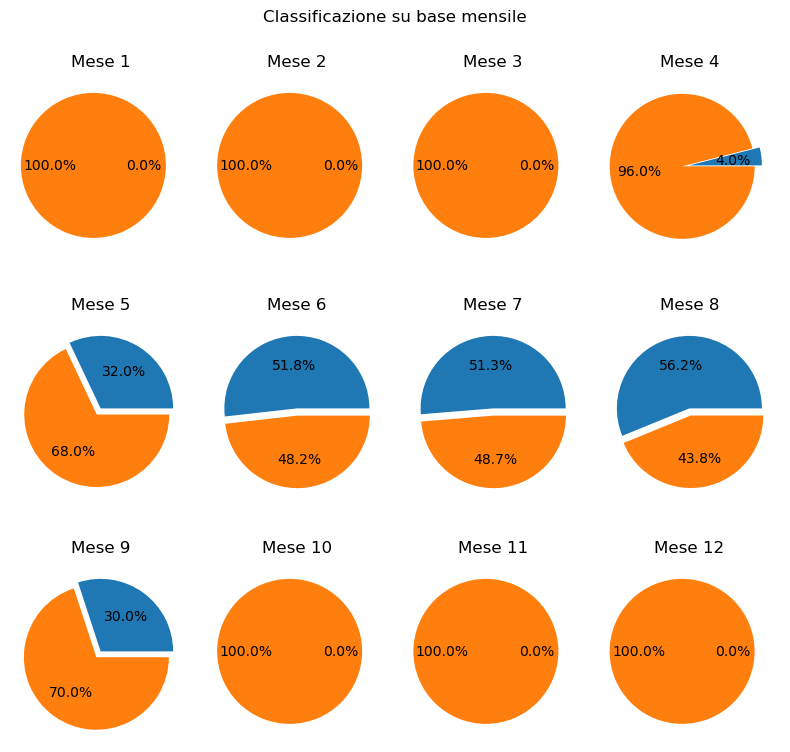

In [19]:
#Distribuzione delle classi su base mensile
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(8, 8))

for i in range(12):
    ax = axes[i // 4, i % 4]
    mese = df[df["MONTH"] == i+1]
    ax.pie(mese["BBQ"].value_counts().sort_index()[::-1],#mette prima i True e poi i False
        explode=[0, 0.1], #distanza delle due fette di torta
        autopct='%.1f%%', #formattazione della percentuale
        )
    ax.set_title(f"Mese {i+1}")

plt.suptitle("Classificazione su base mensile")
plt.tight_layout()
plt.show()

## Classificazione meteo rispetto ai parametri meteorologici

### Condizione meteo rispetto ai parametri meteorologici

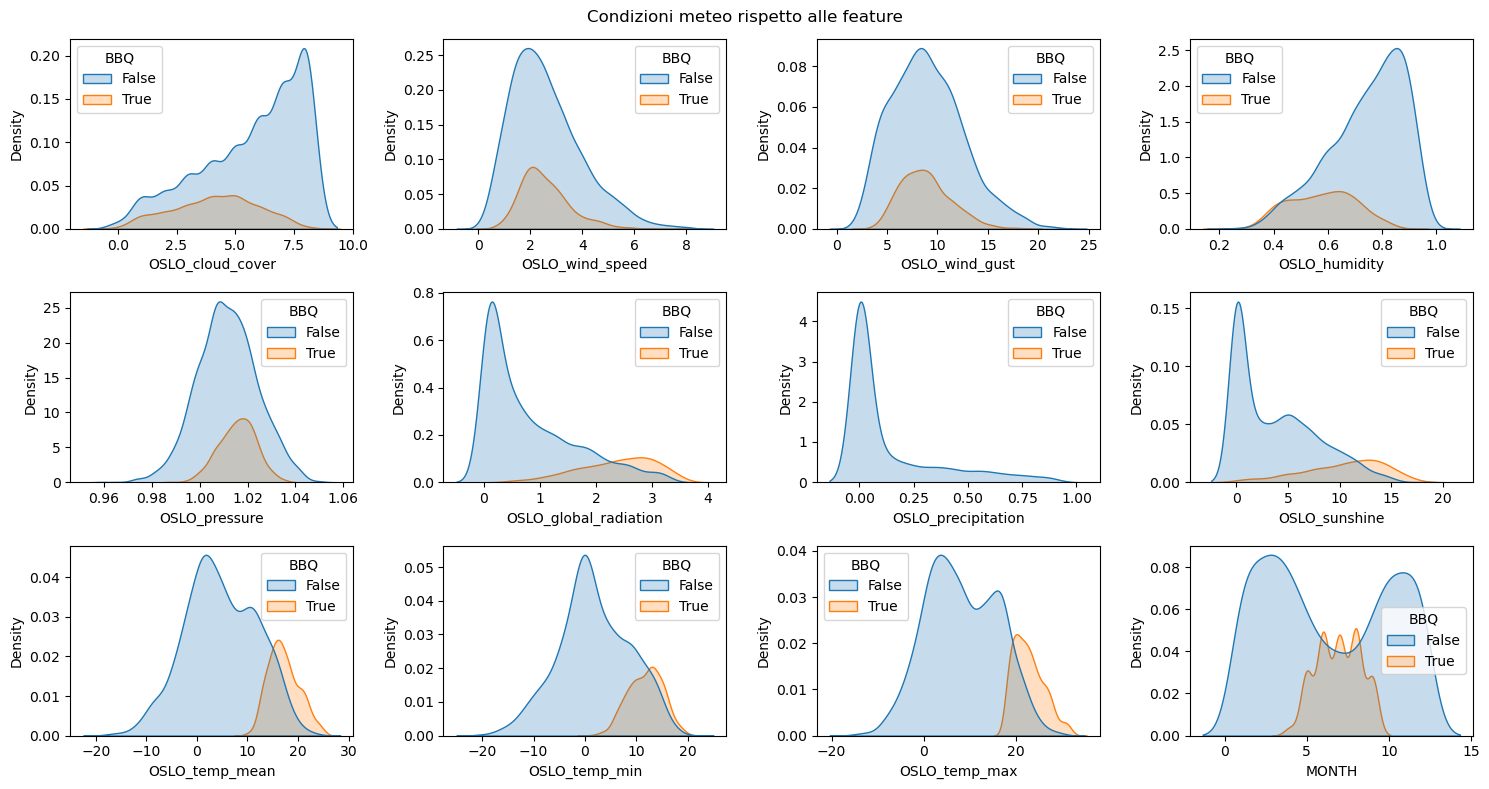

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 8))

for i, colonna in enumerate(colonne_numeriche):
    ax = axes[i // 4, i % 4]
    sns.kdeplot(data = df, x = colonna, hue = "BBQ", fill = True, ax = ax, warn_singular=False)

rimuovi_assi_superflui()
plt.suptitle("Condizioni meteo rispetto alle feature")
plt.tight_layout()
plt.show()

I Kernel Density Plot mostrano la densità di probabilità di avere bello o brutto tempo al variare del valore di un parametro meteorologico misurato. Vengono costruiti facendo uso della PDF (o una sua stima) delle variabili numeriche.

Nel caso della nuvolosità, che è un parametro con distribuzione discreta e non continua, l'approccio non è corretto.
Nel caso delle precipitazioni il codice genera un errore (nascosto con il parametro warn_singular) dovuto al fatto che i valori True si concentrano tutti per precipitazioni 0. Quando si tenta di calcolare una stima della densità (KDE) su un dataset con varianza zero, non è possibile generare una curva di densità significativa, poiché non ci sono dati variabili da rappresentare. In altre parole, non c'è alcuna distribuzione da stimare.
Questo indica che il tempo bbq prevede assenza di precipitazioni.

È possibile notare il legame con la temperatura, dove i valori True si concentrano per temperature alte

### Boxplot dei parametri rispetto alla condizione meteo

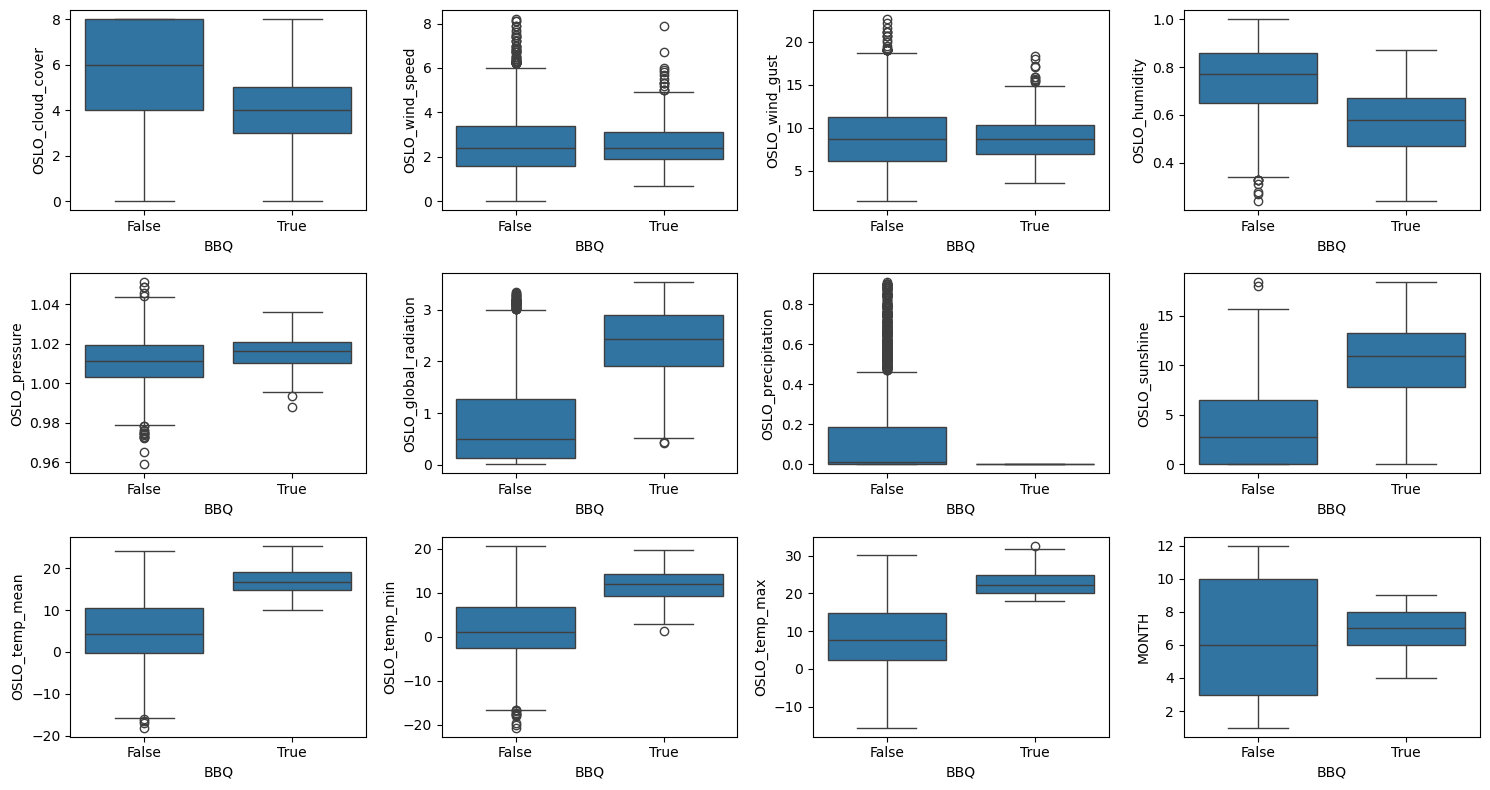

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 8))

for i, colonna in enumerate(colonne_numeriche):
    ax = axes[i // 4, i % 4]
    sns.boxplot(x = "BBQ", y = colonna, data = df, ax = ax)

rimuovi_assi_superflui()
plt.tight_layout()
plt.show()

I boxplot dei parametri meteorologici divisi per classe permettono di analizzare le distribuzioni dei valori dei parametri in funzione della classe di appartenenza, similmente al KDE plot.

## Matrice di correlazione dei parametri meteorologici

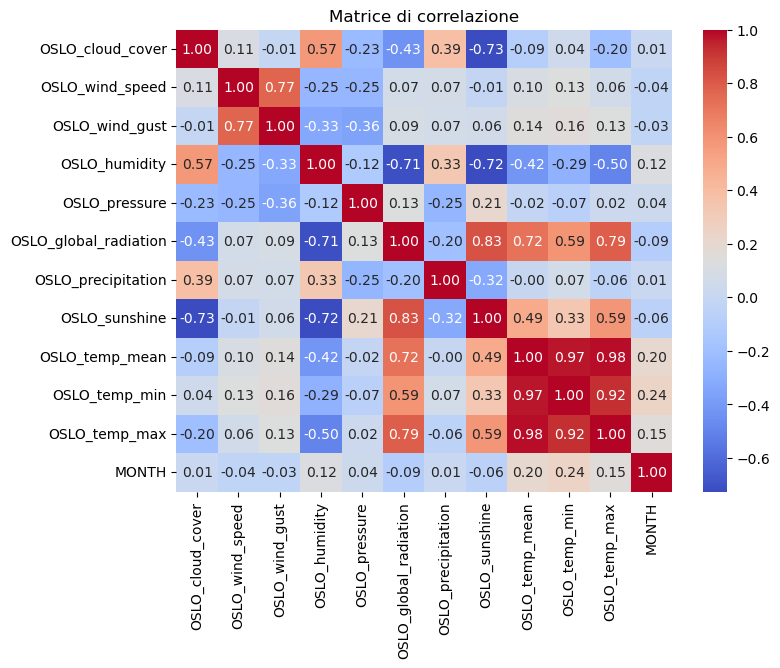

In [22]:
matrice_correlazione = colonne_numeriche.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(matrice_correlazione, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice di correlazione')
plt.show()

Tramite la matrice di correlazione è possibile notare la stretta relazione fra temperatura media, minima e massima, oppure tra velocità del vento e velocità delle raffiche di vento. Inoltre sono in stretta correlazione temperatura (media e massima) e irraggiamento, ore di luce e nuvolosità, umidità e irraggiamento, irraggiamento e ore di luce.

## Analisi bivariate di parametri meteorologici con correlazione alta

### Ore di luce in base alla nuvolosità

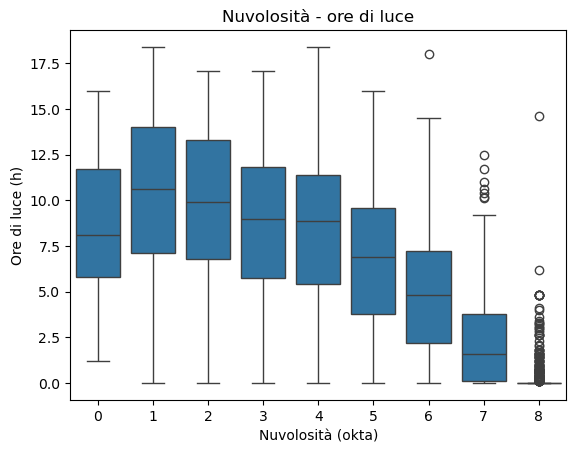

In [23]:
sns.boxplot(x = f"{citta}_cloud_cover", y = f"{citta}_sunshine", data = df)
plt.title("Nuvolosità - ore di luce")
plt.xlabel("Nuvolosità (okta)")
plt.ylabel("Ore di luce (h)")
plt.show()

Avendo indice di correlazione pari a 0.69, viene studiata la loro variazione congiunta. La nuvolosità è una variabile con distribuzione discreta, quindi si fa uso di boxplot per osservare la distribuzione delle ore di luce (variabile con distribuzione continua) in funzione della nuvolosità.
La presenza di ore di luce anche nei giorni con nuvolosità 8 oaks è giustificabile dalla presenza di luce diffusa.

### Irraggiamento - ore di luce

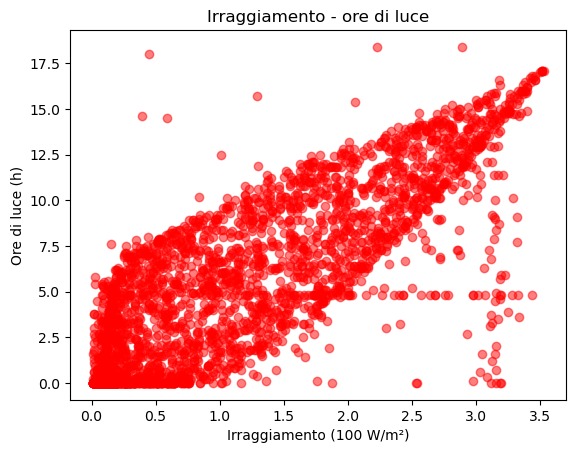

In [24]:
plt.scatter(df[f"{citta}_global_radiation"], df[f"{citta}_sunshine"], alpha=0.5, color="red")
plt.title("Irraggiamento - ore di luce")
plt.xlabel("Irraggiamento (100 W/m²)")
plt.ylabel("Ore di luce (h)")
plt.show()

Irraggiamento e ore di luce hanno indice di correlazione pari a 0.77. Sono entrambe variabili con distribuzione continua, quindi si può far uso di scatter-plot.

### Temperatura minima - temperatura massima

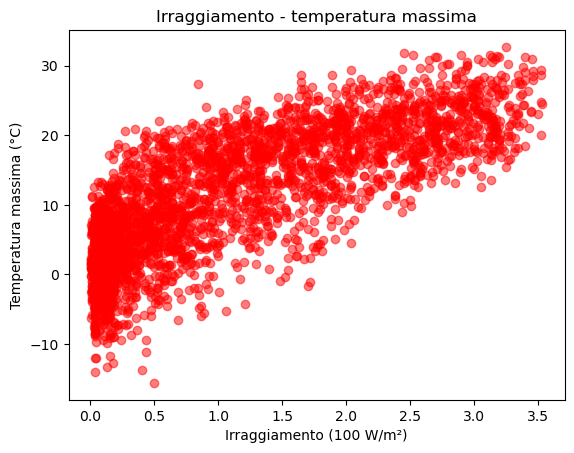

In [25]:
plt.scatter(df[f"{citta}_global_radiation"], df[f"{citta}_temp_max"], alpha=0.5, color="red")
plt.title("Irraggiamento - temperatura massima")
plt.xlabel("Irraggiamento (100 W/m²)")
plt.ylabel("Temperatura massima (°C)")
plt.show()

### Irraggiamento - umidità

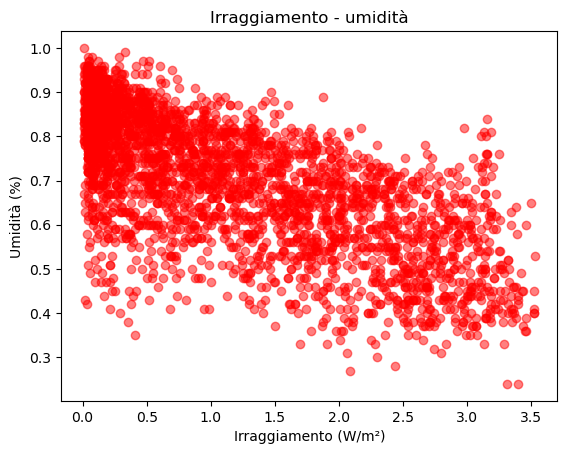

In [26]:
plt.scatter(df[f"{citta}_global_radiation"], df[f"{citta}_humidity"], alpha=0.5, color="red")
plt.title("Irraggiamento - umidità")
plt.xlabel("Irraggiamento (W/m²)")
plt.ylabel("Umidità (%)")
plt.show()

## Analisi multivariata

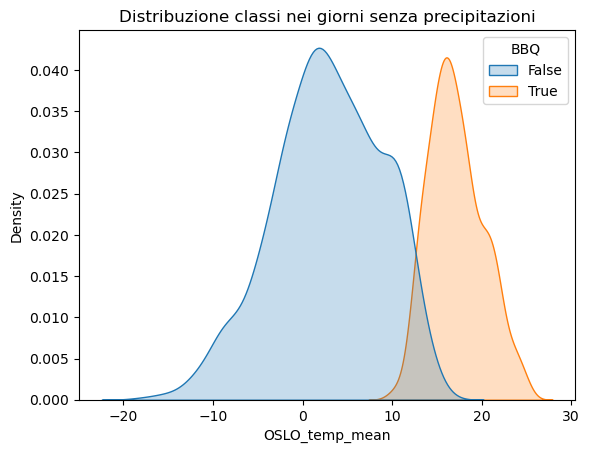

<Figure size 500x500 with 0 Axes>

In [27]:
# Distribuzione classi rispetto alla temperatura media nelle giornate senza precipitazioni
precipitazioni_assenti = df[df[f"{citta}_precipitation"] == 0]
sns.kdeplot(data = precipitazioni_assenti, x = f"{citta}_temp_mean", hue = "BBQ", fill = True)
plt.title("Distribuzione classi nei giorni senza precipitazioni")
plt.figure(figsize = (5,5))
plt.show()

Avendo notato che le classi True sono presenti solo nei giorni senza precipitazioni, viene studiato la distribuzione delle classi rispetto alla temperatura media nei giorni con assenza di precipitazioni. Si noti come la distribuzione differisca rispetto all'analisi bivariata non condizionata di temperatura media - condizione meteo.
Le due classi sono separate in maniera più netta, suggerendo che la temperatura superiore a 10 gradi sia un ulteriore requisito per considerare bel tempo.

# Splitting

In [28]:
#Funzione per dividere il dataset in training set e testing set (80 - 20)
def splitting(random_seed):
    X = colonne_numeriche.values
    y = df["BBQ"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
    return X_train, X_test, y_train, y_test

# Divisione del dataset in train set e test set
X_train, X_test, y_train, y_test = splitting(42)

Dividiamo il dataset in training set (80% dei dati) e testing set (20% dei dati). 

# Addestramento modelli

In [29]:
# Scelta di alcuni modelli standard per l'addestramento

#Logistic Regression
#Non mostra i warning riguardanti i casi in cui il modello non raggiunge la convergenza
warnings.filterwarnings("ignore", category=ConvergenceWarning)
model_logistic_regression = LogisticRegression(max_iter=100)

#SVC
k = "linear"
c = 10
model_SVC = SVC(kernel = k, C = c)

#SVM poly
k = "poly"
d = 3
model_SVM_poly = SVC(kernel = k, C = c, degree=d)

#SVM rbf
k = "rbf"
g = 1
model_SVM_rbf = SVC(kernel = k, C = c, gamma = g)


modelli_SVM = [model_SVC, model_SVM_poly, model_SVM_rbf]

#Addestramento dei modelli sul training set
model_logistic_regression.fit(X_train, y_train)

for modello in modelli_SVM:
    modello.fit(X_train, y_train)


Vengono addestrati 4 modelli: Regressione Logistica, SVC lineare, SVM con kernel polinomiale e SVM con kernel radiale (o esponenziale). In tutti i modelli vengono impostati valori standard per gli iperparametri.

# Hyperparameter tuning

## Validation dataset

In [30]:
# Divisione del testing set in validation e testing (50 - 50)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

Il dataset di testing viene diviso in due, una metà viene usata come validation set e il restante rimane testing dataset. Il risultato quindi è che rispetto al dataset totale il testing set contiene il 10% dei dati, così come il validation. 

## Definizione dei valori degli iperparametri da testare

In [31]:
# Definisce alcuni valori degli iperparametri per SVM 
param_grid_SVC = {
    'C': [0.1, 1, 10, 100],
    'degree': [2, 3, 4],  # Solo per il kernel 'poly'
    'gamma': ['scale', 'auto', 1]  # Solo per i kernel 'rbf' e 'poly'
}

# Definisce alcuni valori degli iperparametri per Regressione Logistica
param_grid_logistic_regression = {
    'solver' : ['saga', 'liblinear'],
    'C': [0.1, 1, 10, 100]
}


Durante la fase di hyperparameter tuning viene cercata la combinazione di iperparametri (fra i valori definiti in questa sezione) che porti il modello ad avere un'accuratezza più alta.

## Hyperparameter tuning su modelli SVM

In [32]:
modello_migliore_SVM = None
accuratezza_SVM = 0
parametri_migliori_SVM = {}

for modello in modelli_SVM:
    
    # Prova ogni modello con tutte le combinazioni degli iperparametri proposti.
    grid_search = GridSearchCV(modello, param_grid_SVC, cv=5, scoring='accuracy')
    grid_search.fit(X_val, y_val)
    
    # Mantiene salvato il modello con accuratezza migliore e i suoi parametri associati
    if grid_search.best_score_ > accuratezza_SVM:
        accuratezza_SVM = grid_search.best_score_
        modello_migliore_SVM = grid_search.best_estimator_
        parametri_migliori_SVM = grid_search.best_params_

print("Miglior modello SVC:", modello_migliore_SVM)
print("Migliori parametri SVC:", parametri_migliori_SVM)
print("Accuratezza SVC sul validation set:", accuratezza_SVM)

Miglior modello SVC: SVC(C=100, degree=2, kernel='linear')
Migliori parametri SVC: {'C': 100, 'degree': 2, 'gamma': 'scale'}
Accuratezza SVC sul validation set: 0.9668023518769788


Per ogni modello SVM precedentemente addestrato viene fatto hyperparameter tuning tramite GridSearchCV. Questa operazione consiste nel test dell'accuratezza del modello con tutte le combinazioni di iperparametri possibili utilizzando i valori definiti. 
Nella variabile *modello_migliore_SVM* viene mantenuto il modello con accuratezza maggiore fra tutti quelli provati.

## Hyperparameter tuning su modello Regressione Logistica

In [33]:
# Prova il modello con ogni combinazione di valori definiti per gli iperparametri
grid_search_logistica = GridSearchCV(model_logistic_regression, param_grid_logistic_regression, cv=5, scoring='accuracy')
grid_search_logistica.fit(X_val, y_val)

# Determina il miglior estimatore e i migliori parametri
modello_migliore_logistica = grid_search_logistica.best_estimator_
parametri_migliori_logistica = grid_search_logistica.best_params_

# Accuratezza del modello migliore sul validation set
accuratezza_logistica = grid_search_logistica.best_score_

print("Miglior modello Regressione Logistica:", modello_migliore_logistica)
print("Migliori parametri Regressione Logistica:", parametri_migliori_logistica)
print("Accuratezza Regressione Logistica sul validation set:", accuratezza_logistica)

Miglior modello Regressione Logistica: LogisticRegression(C=100, solver='liblinear')
Migliori parametri Regressione Logistica: {'C': 100, 'solver': 'liblinear'}
Accuratezza Regressione Logistica sul validation set: 0.9457711442786069


Analogamente a quanto fatto prima per i modelli SVM, vengono testate le varie combinazioni di valori degli iperparametri sul modello di Regressione Logistica, determinando quella che determina accuratezza maggiore.

## Selezione del modello migliore

In [34]:
# Sceglie il miglior modello in base all'accuratezza
modello = None
accuratezza_validation = 0
if accuratezza_SVM > accuratezza_logistica:
    modello = modello_migliore_SVM
    accuratezza_validation = accuratezza_SVM
else:
    modello = modello_migliore_logistica
    accuratezza_validation = accuratezza_logistica

print(f"Modello scelto: {modello}")

Modello scelto: SVC(C=100, degree=2, kernel='linear')


Viene selezionato come modello quello con accuratezza più alta fra il miglior modello SVM e il miglior modello di Regressione Logistica

# Valutazione delle performance

## Matrice di confusione

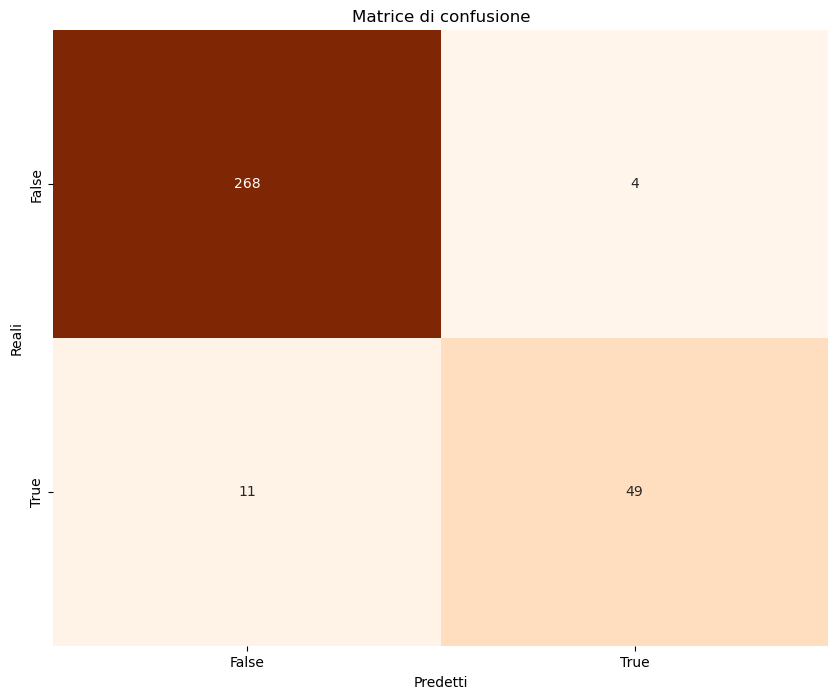

In [35]:
# Effettua le predizioni sul testing set
y_pred = modello.predict(X_test)

#Calcola matrice di confusione
matrice_confusione = confusion_matrix(y_test, y_pred)

# Creazione dell'heatmap della matrice di confusione
plt.figure(figsize=(10, 8))
labels = ['False', 'True']
sns.heatmap(matrice_confusione, annot=True, fmt="d", cmap="Oranges", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Matrice di confusione")
plt.xlabel("Predetti")
plt.ylabel("Reali")
plt.show()


## Metriche

In [51]:
#Funzione per calcolo delle metriche a partire dalla matrice di confusione
def calcolo_metriche(matrice_confusione):
    
    tn, fp, fn, tp = matrice_confusione.ravel()

    accuratezza = (tp + tn) / (tp + tn + fp + fn)
    sensitivita = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificita = tn / (tn + fp) if (tn + fp) > 0 else 0
    precisione = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0

    return accuratezza, sensitivita, specificita, precisione, npv

#Calcolo delle metriche
accuratezza, sensitivita, specificita, precisione, npv = calcolo_metriche(matrice_confusione)

# Stampa metriche
print("METRICHE MODELLO:")
print(f"Accuratezza: {accuratezza:.4f}")
print(f"Tasso di Misclassificazione (MR): {(1 - accuratezza):.4f}")
print(f"Sensitività: {sensitivita:.4f}")
print(f"Specificità: {specificita:.4f}")
print(f"Precisione: {precisione:.4f}")
print(f"Valore Predittivo Negativo (NPV): {npv:.4f}")

METRICHE MODELLO:
Accuratezza: 0.9804
Tasso di Misclassificazione (MR): 0.0196
Sensitività: 0.9550
Specificità: 0.9855
Precisione: 0.9298
Valore Predittivo Negativo (NPV): 0.9909


## Overfitting e underfitting

In [37]:
#Effettua predizione sul training set per valutare overfitting/underfitting
y_pred_train = modello.predict(X_train)

print(f"Accuratezza sul testing set: {accuratezza:.4f}")
print(f"Accuratezza sul validation set: {accuratezza_validation:.4f}")
print(f"Accuratezza sul training set: {(accuracy_score(y_train, y_pred_train)):.4f}")

Accuratezza sul testing set: 0.9548
Accuratezza sul validation set: 0.9668
Accuratezza sul training set: 0.9529


L'accuratezza non varia di molto fra training set e testing set, quindi il modello non soffre eccessivamente di over-fitting o under-fitting. 

# Studio statistico sui risultati della valutazione

## Generazione dei campioni

In [38]:
# Dimensione dei campioni delle metriche
k = 20

#Dizionario con chiavi le metriche e valori la lista di k valori misurati per ogni metrica
metriche_srs = {
    'accuratezza': [],
    'sensitivita': [],
    'specificita': [],
    'precisione': [],
    'npv': []
}


for seed in range(1, k+1):

    #Generazione di un nuovo training set e testing set
    X_train, X_test, y_train, y_test = splitting(seed)

    #Training e testing del modello
    modello.fit(X_train, y_train)
    y_pred = modello.predict(X_test)

    #Calcolo della matrice di confusione
    matrice_confusione = confusion_matrix(y_test, y_pred)

    #Calcolo delle metriche e inserimento dei valori nel dizionario
    metriche = calcolo_metriche(matrice_confusione)
    metriche_srs['accuratezza'].append(metriche[0]) 
    metriche_srs['sensitivita'].append(metriche[1])  
    metriche_srs['specificita'].append(metriche[2])  
    metriche_srs['precisione'].append(metriche[3])  
    metriche_srs['npv'].append(metriche[4])


Generazione di k training e testing set per svolgere altrettante operazioni di training e testing del modello. Il testing viene utilizzato per calcolare le metriche, che vengono di volta in volta inserite in un dizionario. Al termine si ottiene quindi per ogni metrica un campione di k valori, utile per uno studio statistico sulla valutazione del modello

## Stima media e intervallo di confidenza

In [39]:
#Funzione per calcolare l'intervallo di confidenza per la media di un campione di n elementi
def inferenza_media(n, campione, alfa):
    media = np.mean(campione) #calcola la media del campione
    S_2 = campione.var(ddof = 1) #stimatore corretto della varianza
    S = math.sqrt(S_2) #deviazione standard stimata
    limite_superiore = limite_inferiore = 0
    
    if n < 40: #se l'intervallo ha meno di 40 elementi utilizza il quantile della distribuzione t di student
        t_value = t.ppf(1 - alfa/2, n-1)
        limite_inferiore = media - t_value * (S / math.sqrt(n))
        limite_superiore = media + t_value * (S / math.sqrt(n))
    
    else: #se l'intervallo ha 40 o più elementi utilizza il quantile della distribuzione normale
        z_value = norm.ppf(1 - alfa/2)
        limite_inferiore = media - z_value * (S / math.sqrt(n))
        limite_superiore = media + z_value * (S / math.sqrt(n))
        
    print(f"Intervallo di confidenza della media: [{limite_inferiore:.4f}; {limite_superiore:.4f}]")

La funzione calcola l'intervallo di confidenza della media al (1 - alfa)% per un campione di n elementi di cui la varianza non è nota. Viene stimata la deviazione standard tramite lo stimatore corretto della varianza, e viene calcolato l'intervallo di confidenza in base alla dimensinoe del campione. 

## Descrizione campioni e inferenza della media

Numero di elementi dei campioni: 20
Studio statistico sui risultati della valutazione:

ACCURATEZZA
Media: 0.9791
Intervallo di confidenza della media: [0.9767; 0.9816]
Mediana: 0.9789
Deviazione standard: 0.0052
IQR: 0.0064


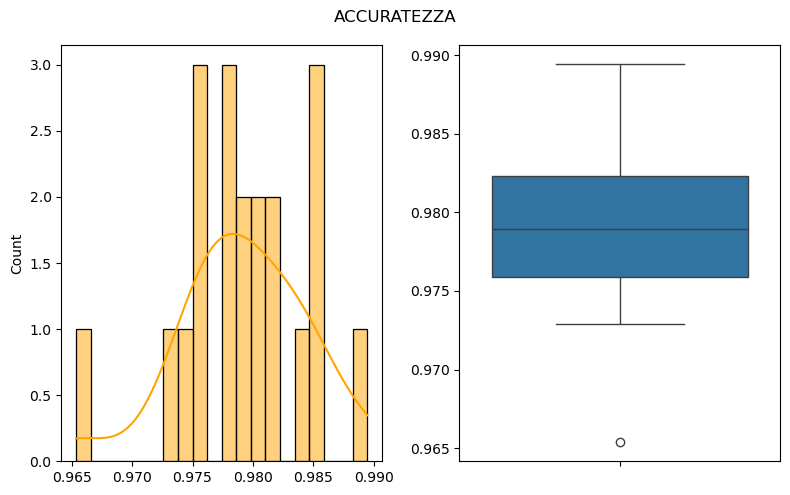


SENSITIVITA
Media: 0.9629
Intervallo di confidenza della media: [0.9539; 0.9719]
Mediana: 0.9667
Deviazione standard: 0.0188
IQR: 0.0226


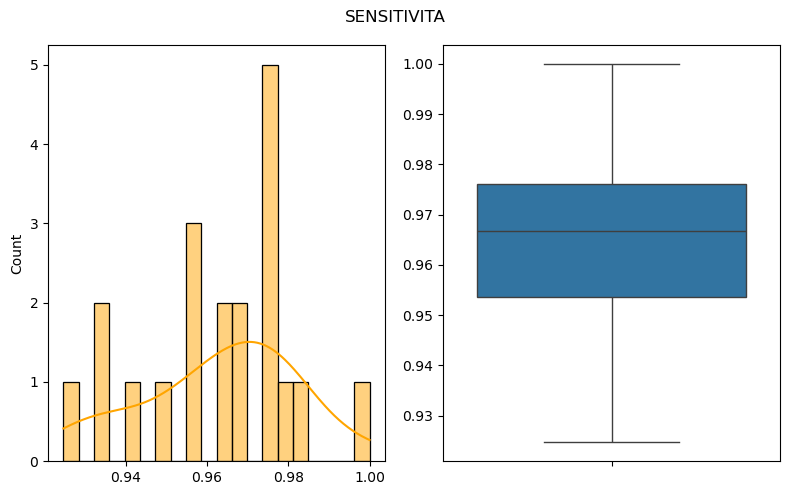


SPECIFICITA
Media: 0.9830
Intervallo di confidenza della media: [0.9805; 0.9855]
Mediana: 0.9844
Deviazione standard: 0.0052
IQR: 0.0102


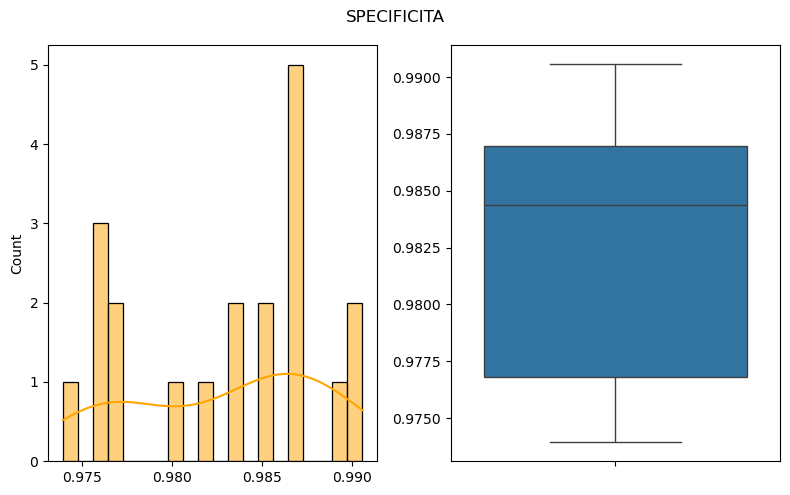


PRECISIONE
Media: 0.9278
Intervallo di confidenza della media: [0.9169; 0.9388]
Mediana: 0.9306
Deviazione standard: 0.0229
IQR: 0.0370


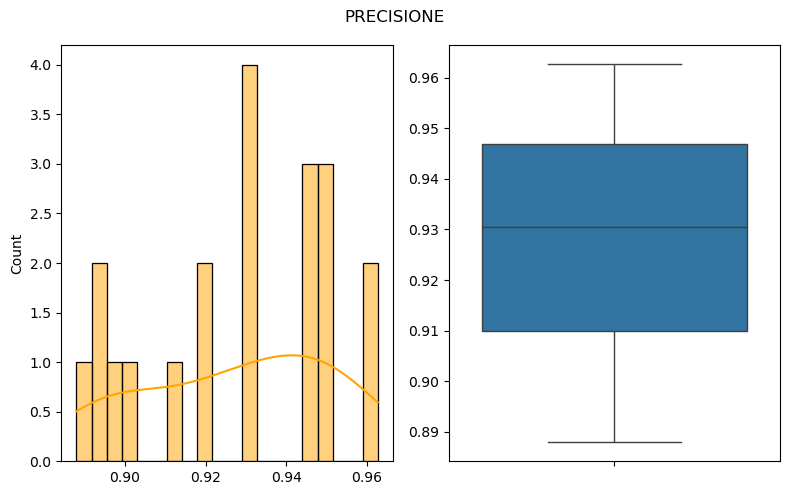


NPV
Media: 0.9913
Intervallo di confidenza della media: [0.9890; 0.9936]
Mediana: 0.9925
Deviazione standard: 0.0048
IQR: 0.0048


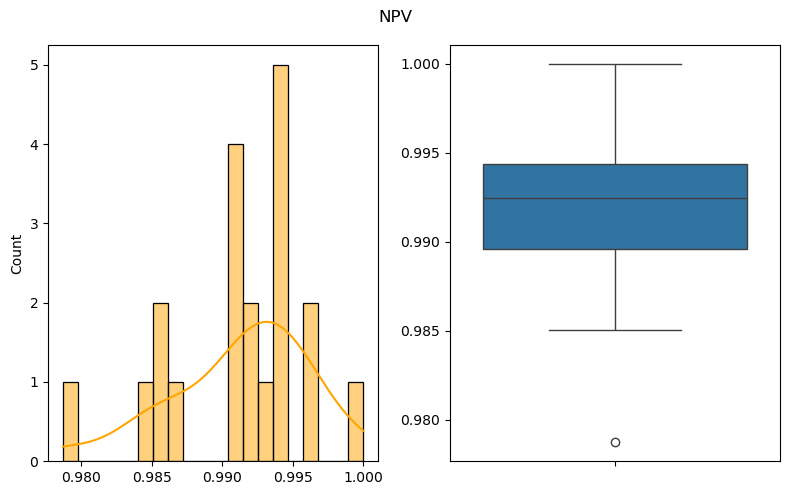

In [40]:
print(f"Numero di elementi dei campioni: {k}")
print("Studio statistico sui risultati della valutazione:")
print()
# Ciclo sulle metriche del dizionario
# Per ogni metrica viene effettuata un'analisi descrittiva del campione e viene fatta inferenza sulla media
for metrica in metriche_srs:
    #Selezione del campione, trasformato in array numpy
    metriche_srs[metrica] = np.array(metriche_srs[metrica])
    campione = metriche_srs[metrica]

    #Calcolo delle misure di statistica descrittiva
    print(f"{metrica.upper()}")
    print(f"Media: {(np.mean(campione)):.4f}")
    inferenza_media(len(campione), campione, 0.05) #calcolo dell'intervallo di confidenza della media
    print(f"Mediana: {(np.median(campione)):.4f}")
    
    print(f"Deviazione standard: {(np.std(campione)):.4f}")
    print(f"IQR: {(np.percentile(campione, 75) - np.percentile(campione, 25)):.4f}")

    #Stampa dei grafici di distribuzione dei valori
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
    
    sns.histplot(campione, kde = True, bins = k, color="orange", ax = axes[0]) #istogramma
    sns.boxplot(data = campione, ax = axes[1]) #boxplot

    plt.suptitle(f"{metrica.upper()}")
    plt.tight_layout()
    plt.show()
    print()



Per ogni metrica vengono calcolate misure del centro (media, mediana), misure della diffusione (varianza, IQR) e vengono disegnati l'istogramma con curva di densità e il boxplot del campione. Viene anche calcolato l'intervallo di confidenza al 95% della media.
La studio delle metriche su un campione di valori rende più affidabile la valutazione perchè meno soggetta alla scelta casuale del testing set.

La sensitivià indica la capacità del modello di identificare correttamente le classi True, mentre la specificità indica la capacità di identificare correttamente le classi False. La differenza del 3% nei valori medi delle due metriche è giustificata dal class imbalance, tuttavia non sono effetti così drastici. 
La precisione invece indica l'affidabilità delle predizioni True, mentre NPV (Negative Predicted Value) indica l'affidabilità delle predizioni False. Fra i due c'è una differenza di circa il 6%, giustificata dal class imbalance.

# Regressione

## Addestramento del modello e predizione

In [41]:
# Imposta variabile indipendente e variabile dipendente
X = df[f"{citta}_temp_min"].values.reshape(-1, 1)
Y_osservati = df[f"{citta}_temp_max"]

#Training del modello di regressione lineare
modello_regressione_lineare = LinearRegression()
modello_regressione_lineare.fit(X, Y_osservati)

#Predizione tramite il modello
Y_predetti = modello_regressione_lineare.predict(X)

La temperatura minima giornaliera viene considerata la variabile indipendente a partire dalla quale fare regressione lineare e predire la temperatura massima giornaliera, ossia la variabile dipendente.

## Parametri di regressione

In [42]:
#Parametri retta di regressione
intercetta = modello_regressione_lineare.intercept_
coefficiente_angolare = modello_regressione_lineare.coef_[0]
print(f"Intercetta (beta 0): {intercetta:.2f}")
print(f"Pendenza (beta 1): {coefficiente_angolare:.2f}")

Intercetta (beta 0): 6.99
Pendenza (beta 1): 1.11


Calcola i due parametri dell'equazione della retta di regressione stimati dal modello in fase di training: l'intercetta (beta0) e il coefficiente angolare (beta1). 

## Grafico retta di regressione

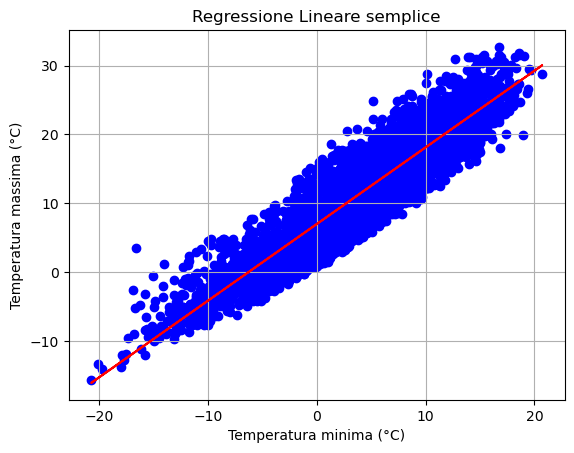

In [43]:
# Disegna i punti osservati (in blu) e la retta di regressione (in rosso)
plt.scatter(X, Y_osservati, color='blue')
plt.plot(X, Y_predetti, color='red')

plt.xlabel("Temperatura minima (°C)")
plt.ylabel('Temperatura massima (°C)')
plt.title('Regressione Lineare semplice')
plt.grid(True) #mostra la griglia per dare visibilità all'intercetta
plt.show()

Stampa in uno scatter-plot i punti del dataset in blu e i punti stimati dal modello di regressione lineare in rosso. I punti stimati dal modello sono disposti lungo una retta, difatti il modello approssima ad una relazione lineare la relazione fra variabile temperatura minima e massima.

## Metriche di valutazione

In [44]:
print(f"r²: {(r2_score(Y_osservati, Y_predetti)):.4f}")
print(f"MSE: {(mean_squared_error(Y_osservati, Y_predetti)):.4f} °C²")

r²: 0.8450
MSE: 12.9536 °C²


Per l'84% dei casi a partire dalla temperatura minima il modello predice correttamente la temperatura massima. L'errore quadratico medio è di 12.95. 

## Analisi di normalità dei residui

In [45]:
#Calcolo residui
residui = Y_osservati - Y_predetti

### Distribuzione residui

Media dei residui: 1.1142e-16


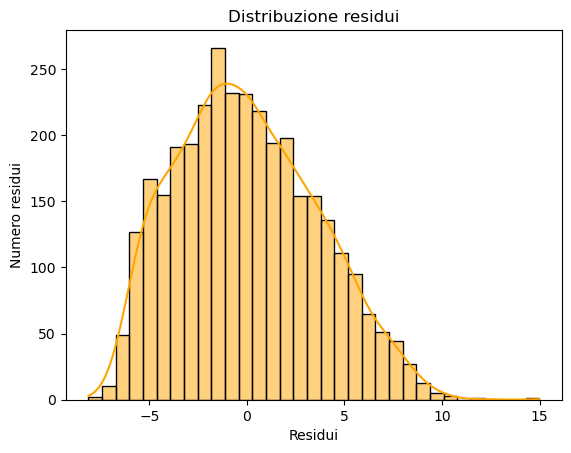

In [46]:
#Istogramma per osservare la distribuzione dei residui
sns.histplot(residui, kde = True, color="orange")
plt.xlabel("Residui")
plt.ylabel("Numero residui")
plt.title("Distribuzione residui")

#Valore medio dei residui
print(f"Media dei residui: {(np.mean(residui)):.4e}")

L'istogramma mostra come i residui seguano una distribuzione molto vicina a quella normale. Il valore medio dei residui è 0.

### Outliers residui

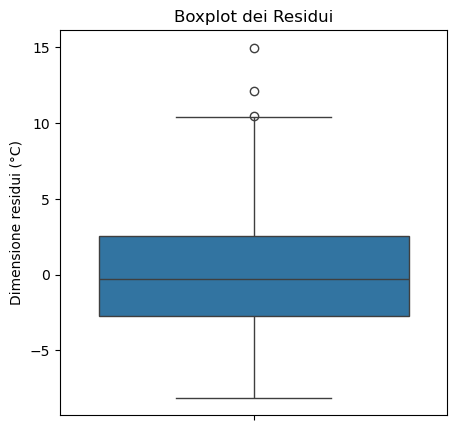

In [47]:
plt.figure(figsize = (5, 5))
sns.boxplot(residui)
plt.title('Boxplot dei Residui')
plt.ylabel("Dimensione residui (°C)")
plt.show()

Studia la presenza di outliers fra i residui che possano influenzare l'analisi di normalità. Sono presenti solo tre outliers potenziali.

### Dimensione residui

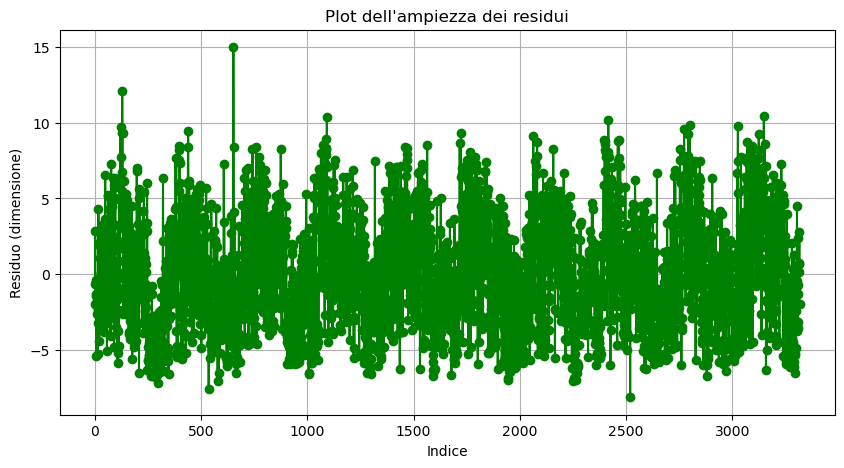

In [52]:
#Dimensione residui
plt.figure(figsize=(10, 5))
indici = list(range(1, len(residui) + 1))
plt.plot(indici, residui, color="green", linestyle="-", marker="o")
plt.xlabel("Indice")
plt.ylabel("Residuo (dimensione)")
plt.title("Plot dell'ampiezza dei residui")
plt.grid(True)
plt.show()

Analizza la dimensione dei residui e le loro oscillazioni.

### QQ-Plot

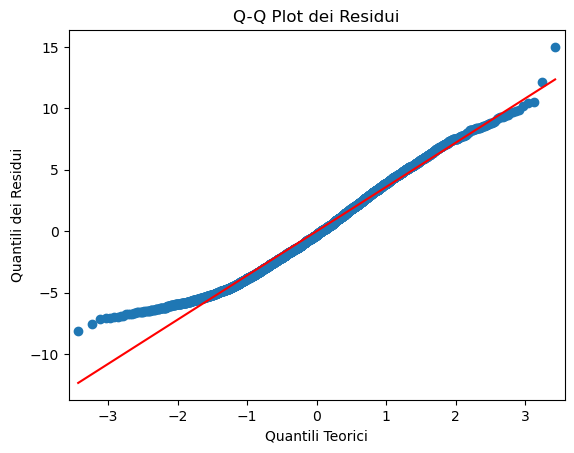

In [48]:
# Q-Q plot
sm.qqplot(residui, line='s')
plt.title('Q-Q Plot dei Residui')
plt.xlabel('Quantili Teorici')
plt.ylabel('Quantili dei Residui')
plt.show()

Il QQ plot confronta i quantili di una distribuzione normale standard con i quantili dei residui. Se i punti si dispongono sulla retta, pur avendo sui due assi valori differenti, significa che la distribuzione dei residui è normale. 
In questo caso la distribuzione dei residui è considerabile normale.

### Test di Shapiro

In [49]:
# Verifica normalità dei residui (test di Shapiro-Wilk)
shapiro_test = shapiro(residui)
print(f"Test di Shapiro-Wilk p-value: {(shapiro_test.pvalue):.4e}")

Test di Shapiro-Wilk p-value: 4.2677e-19


Il test di Shapiro-Wilk è un test di verifica della normalità di un campione. Esso prevede il calcolo di un indice W per cui viene poi stimato il p-value. Nel caso dei residui del modello di regressione lineare, il p-value del test di Shapiro-Wilk è estremamente inferiore a 0.05 e 0.01, risultato che solitamente porta al rifiuto dell'ipotesi nulla in favore dell'ipotesi alternativa, ossia che la distribuzione dei residui sia non normale. 
In questo caso invece, considerata l'efficacia del modello predittivo (che ha come presupposto la distribuzione normale dei residui), considerato che il valore medio dei residui è 0, e considerati i risultati del QQ-plot, concludiamo che l'ipotesi di residui con distribuzione normale con media 0 è soddisfatta. 